In this jupyter notebook, we will be analyzing plate reader data from experiments used to determine appropriate inducer concentrations (Las-AHL inducing pi-protein expression) for 1x and 2x differerentiation strains, and generating plots as shown in Supplementary Figures 6-9.

In [1]:
# NumPy and odeint, our workhorses
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from cycler import cycler
from sklearn.linear_model import LinearRegression

sns.set_context("talk", font_scale=1.5, rc={"lines.linewidth": 1.5})
sns.set_style("ticks")
sns.set_style({"xtick.direction": "in","ytick.direction": "in"})


mpl.rc('axes', prop_cycle=(cycler('color', ['r', 'k', 'b','g','y','m','c']) ))

mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
tw = 1.5
sns.set_style({"xtick.major.size": 3, "ytick.major.size": 3,
               "xtick.minor.size": 2, "ytick.minor.size": 2,
               'axes.labelsize': 16, 'axes.titlesize': 16,
               'xtick.major.width': tw, 'xtick.minor.width': tw,
               'ytick.major.width': tw, 'ytick.minor.width': tw})

mpl.rc('xtick', labelsize=14) 
mpl.rc('ytick', labelsize=14)
mpl.rc('axes', linewidth=1.5)
mpl.rc('legend', fontsize=14)
mpl.rc('legend', frameon=False)
mpl.rc('figure', figsize=(8.5,15))
%matplotlib qt



Load data and generate tidy dfs. In reading the mScarlet values for the second plate, some of them were saturated, so i repeated the read using a lower gain. I already checked in excel that I can convert values from the lower gain to the higher gain, (it is perfectly linear), so for p1 I will convert the higher gain value to the lower gain value.

In [2]:
# load data
p0 = pd.read_csv('./20211018_diff_plate0.csv')
p1 = pd.read_csv('./20211018_diff_plate1.csv')
p2 = pd.read_csv('./20211018_diff_plate2.csv')
p3 = pd.read_csv('./20211018_diff_plate3.csv')

p0_metadata = pd.read_csv('./20211018_metadata_plate0.csv')
metadata = pd.read_csv('./20211018_metadata.csv')

In [3]:
# make p0 dataframe
columns = list(p0_metadata.columns)
columns += ['plate','channel','gain','measurement']
cols = np.arange(1,25,2)
rows = ['A','B','C','D','E','F','G','H']
reads = p0['read'].unique()
gains = [50,50,80,-1,-1]

data = []
df = p0
for row in rows:
    for col in cols:
        for i, read in enumerate(reads):
            value = df.loc[(df.row==row)&(df.read==read),str(int(col))].values[0]
            channel = read.split('_')[0]
            data_add = list(p0_metadata.loc[p0_metadata.well==row+str(int(col)),:].values.flatten())
            data_add+=[0,channel,gains[i],value]
            data.append(data_add)
df_p0 = pd.DataFrame(columns=columns,data=data)

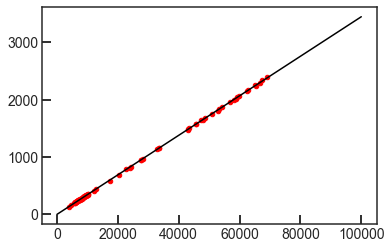

In [4]:
%matplotlib inline
x = df_p0.loc[(df_p0.channel=='mScarlet')&\
                   (df_p0.gain==80),'measurement'].values
y =  df_p0.loc[(df_p0.channel=='mScarlet')&\
                   (df_p0.gain==50),'measurement'].values
plt.plot(x,y,'.')
# linear fit to convert higher gain measurement to lower gain measurement
model = LinearRegression().fit(x.reshape((-1,1)), y)
b = model.intercept_
m = model.coef_[0]
x_fit = np.linspace(0,1e5,300)
y_fit = b + m*x_fit
plt.plot(x_fit,y_fit)

In [5]:
# load p1
columns = list(metadata.columns)
columns += ['plate','channel','gain','read','measurement']
cols = np.arange(1,25)
rows = ['A','B','C','D','E','F','G','H','I','J','K','L','M','N','O','P']
reads = p1['read'].unique()
gains = [50,80,-1,-1,50,80,-1,-1]


In [6]:
data = []

df = p1
for row in rows:
    for col in cols:
        for i, read in enumerate(reads):
            value = df.loc[(df.row==row)&(df.read==read),str(int(col))].values[0]
            channel = read.split('_')[0]
            read_num = read.split('_')[1][0]
            data_add = list(metadata.loc[metadata.well==row+str(int(col)),:].values.flatten())
            data_add+=[1,channel,gains[i],read_num,value]
            data.append(data_add)
p1_master = pd.DataFrame(columns=columns,data=data)

In [7]:
p1_master_avg = p1_master.groupby(['well','strain','sal','las','iptg','chlor','cole1','plate','channel','gain'],as_index=False)['measurement'].mean()
df_p1 = p1_master_avg.copy()
df_p1.loc[df_p1.channel=='mScarlet','measurement']= b + m*p1_master_avg.loc[p1_master_avg.channel=='mScarlet','measurement'].values
df_p1.loc[df_p1.channel=='mScarlet','gain'] = 50

In [8]:
#load data for p2
columns = list(metadata.columns)
columns += ['plate','channel','gain','read','measurement']
cols = np.arange(1,25)
rows = ['A','B','C','D','E','F','G','H','I','J','K','L','M','N','O','P']
reads = np.array(['sfGFP_1:485,515', 'mScarlet_1_1:565,595','OD700_1:700', 
                  'sfGFP_2:485,515', 'mScarlet_1_2:565,595', 'OD700_2:700'])
gains = [50,50,-1,50,50,-1]

data = []

df = p2
for row in rows:
    for col in cols:
        for i, read in enumerate(reads):
            value = df.loc[(df.row==row)&(df.read==read),str(int(col))].values[0]
            channel = read.split('_')[0]
            if read.split('_')[0] == 'mScarlet':
                read_num = read.split('_')[2][0]
            else:
                read_num = read.split('_')[1][0]
            data_add = list(metadata.loc[metadata.well==row+str(int(col)),:].values.flatten())
            data_add+=[2,channel,gains[i],read_num,value]
            data.append(data_add)
p2_master = pd.DataFrame(columns=columns,data=data)
p2_master['measurement'] = p2_master['measurement'].astype('float64') 
df_p2 = p2_master.groupby(['well','strain','sal','las','iptg','chlor','cole1','plate','channel','gain'],as_index=False)['measurement'].mean()
df_p2.head()

,well,strain,sal,las,iptg,chlor,cole1,plate,channel,gain,measurement
0,A1,1x diff 2x bxb1,0,0.30,10,+,carb,2,OD700,-1,1.4795
1,A1,1x diff 2x bxb1,0,0.30,10,+,carb,2,mScarlet,50,691.5000
2,A1,1x diff 2x bxb1,0,0.30,10,+,carb,2,sfGFP,50,263.0000
3,A10,split pir 2x bxb1,0,0.03,10,+,carb,2,OD700,-1,1.5220
4,A10,split pir 2x bxb1,0,0.03,10,+,carb,2,mScarlet,50,4173.0000


In [9]:
#load data for p3
columns = list(metadata.columns)
columns += ['plate','channel','gain','read','measurement']
cols = np.arange(1,25)
rows = ['A','B','C','D','E','F','G','H','I','J','K','L','M','N','O','P']
reads = np.array(['sfGFP_1:485,515', 'mScarlet_1_1:565,595','OD700_1:700', 
                  'sfGFP_2:485,515', 'mScarlet_1_2:565,595', 'OD700_2:700'])
gains = [50,50,-1,50,50,-1]

data = []

df = p3
for row in rows:
    for col in cols:
        for i, read in enumerate(reads):
            value = df.loc[(df.row==row)&(df.read==read),str(int(col))].values[0]
            channel = read.split('_')[0]
            if read.split('_')[0] == 'mScarlet':
                read_num = read.split('_')[2][0]
            else:
                read_num = read.split('_')[1][0]
            data_add = list(metadata.loc[metadata.well==row+str(int(col)),:].values.flatten())
            data_add+=[3,channel,gains[i],read_num,value]
            data.append(data_add)
p3_master = pd.DataFrame(columns=columns,data=data)
p3_master['measurement'] = p3_master['measurement'].astype('float64') 
df_p3 = p3_master.groupby(['well','strain','sal','las','iptg','chlor','cole1','plate','channel','gain'],as_index=False)['measurement'].mean()
df_p3.head()

,well,strain,sal,las,iptg,chlor,cole1,plate,channel,gain,measurement
0,A1,1x diff 2x bxb1,0,0.30,10,+,carb,3,OD700,-1,1.555
1,A1,1x diff 2x bxb1,0,0.30,10,+,carb,3,mScarlet,50,480.000
2,A1,1x diff 2x bxb1,0,0.30,10,+,carb,3,sfGFP,50,235.500
3,A10,split pir 2x bxb1,0,0.03,10,+,carb,3,OD700,-1,1.492
4,A10,split pir 2x bxb1,0,0.03,10,+,carb,3,mScarlet,50,3219.500


In [15]:
df_p0.to_csv('plate0.csv')
df_p1.to_csv('plate1.csv')
df_p2.to_csv('plate2.csv')
df_p3.to_csv('plate3.csv')

In [10]:
df_p1_avg = df_p1.groupby(['strain','sal','las','iptg','chlor','cole1','plate','channel','gain'],as_index=False)['measurement'].mean()
df_p1_avg['std']=df_p1.groupby(['strain','sal','las','iptg','chlor','cole1','plate','channel','gain'])['measurement'].std().values

In [11]:
df_p2_avg = df_p2.groupby(['strain','sal','las','iptg','chlor','cole1','plate','channel','gain'],as_index=False)['measurement'].mean()
df_p2_avg['std']=df_p2.groupby(['strain','sal','las','iptg','chlor','cole1','plate','channel','gain'])['measurement'].std().values

In [12]:
df_p3_avg = df_p3.groupby(['strain','sal','las','iptg','chlor','cole1','plate','channel','gain'],as_index=False)['measurement'].mean()
df_p3_avg['std']=df_p3.groupby(['strain','sal','las','iptg','chlor','cole1','plate','channel','gain'])['measurement'].std().values

In [13]:
df_OD700_avg = pd.concat([df_p1_avg.loc[df_p1_avg.channel=='OD700',:],
                          df_p2_avg.loc[df_p2_avg.channel=='OD700',:],
                          df_p3_avg.loc[df_p3_avg.channel=='OD700',:]])
df_GFP_avg = pd.concat([df_p1_avg.loc[df_p1_avg.channel=='sfGFP',:],
                          df_p2_avg.loc[df_p2_avg.channel=='sfGFP',:],
                          df_p3_avg.loc[df_p3_avg.channel=='sfGFP',:]])
df_RFP_avg = pd.concat([df_p1_avg.loc[df_p1_avg.channel=='mScarlet',:],
                          df_p2_avg.loc[df_p2_avg.channel=='mScarlet',:],
                          df_p3_avg.loc[df_p3_avg.channel=='mScarlet',:]])

Below we generate plots as shown in Supplementary Figures 6-9. We plot mean +/- SD error bars of three replicates.

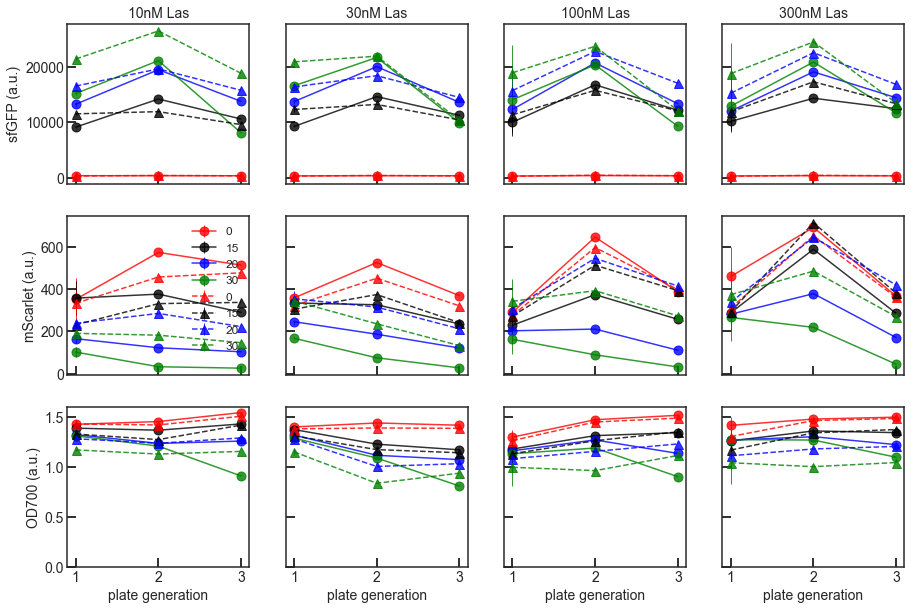

In [14]:
# plots for 1x differetiation (S6 and S8) set cole to 'carb' to get ampR/carb plot
# solid lines are 10uM IPTG, solid are 50uM IPTG
strain = '1x diff 2x bxb1'
iptgs = [10,50]
las_concs = df_OD700_avg.las.unique()
sal_concs = df_OD700_avg.sal.unique()
df_dict = {'GFP':df_GFP_avg,'RFP':df_RFP_avg,'OD700':df_OD700_avg}
fig, ax = plt.subplots(3,4,figsize=(15,10),sharex=True,sharey='row')
channels = ['GFP','RFP','OD700']
cole1='kan' # set to 'carb' to get ampR/carb plot
for i, las in enumerate(las_concs):
    ax[0,i].set_title(f'{int(1000*las)}nM Las',fontsize=14)
    ax[2,i].set_xlabel('plate generation',fontsize=14)
    for k, sal in enumerate(sal_concs):
        for j, channel in enumerate(channels):
            df = df_dict[channel]
            df_plot = df.loc[(df.strain==strain)&\
                             (df.las==las)&\
                             (df.sal==sal)&\
                             (df.iptg==10)&\
                             (df.cole1==cole1),:]
            ax[j,i].errorbar(df_plot['plate'].values,
                             df_plot['measurement'].values,
                             yerr=df_plot['std'].values,
                             linestyle='-',marker='o',color=sns.color_palette()[k],alpha=0.8,lw=1.5,
                            errorevery=5,elinewidth=1)
for i, las in enumerate(las_concs):
    ax[0,i].set_title(f'{int(1000*las)}nM Las',fontsize=14)
    ax[2,i].set_xlabel('plate generation',fontsize=14)
    for k, sal in enumerate(sal_concs):
        for j, channel in enumerate(channels):
            df = df_dict[channel]
            df_plot = df.loc[(df.strain==strain)&\
                             (df.las==las)&\
                             (df.sal==sal)&
                             (df.iptg==50)&\
                             (df.cole1==cole1)]
            ax[j,i].errorbar(df_plot['plate'].values,
                             df_plot['measurement'].values,
                             yerr=df_plot['std'].values,
                             linestyle='--',marker='^',color=sns.color_palette()[k],alpha=0.8,lw=1.5,
                            errorevery=5,elinewidth=1)
ax[2,0].set_ylim(0,1.6)
ax[0,0].set_ylabel('sfGFP (a.u.)',fontsize=14)
ax[1,0].set_ylabel('mScarlet (a.u.)',fontsize=14)
ax[2,0].set_ylabel('OD700 (a.u.)',fontsize=14)
ax[1,0].legend(['0','15','20','30','0','15','20','30'],fontsize=12,loc='best')
plt.savefig(f'./20211209_diff_inducer_grid_las_sal_grad_1xdiff_{cole1}.pdf')

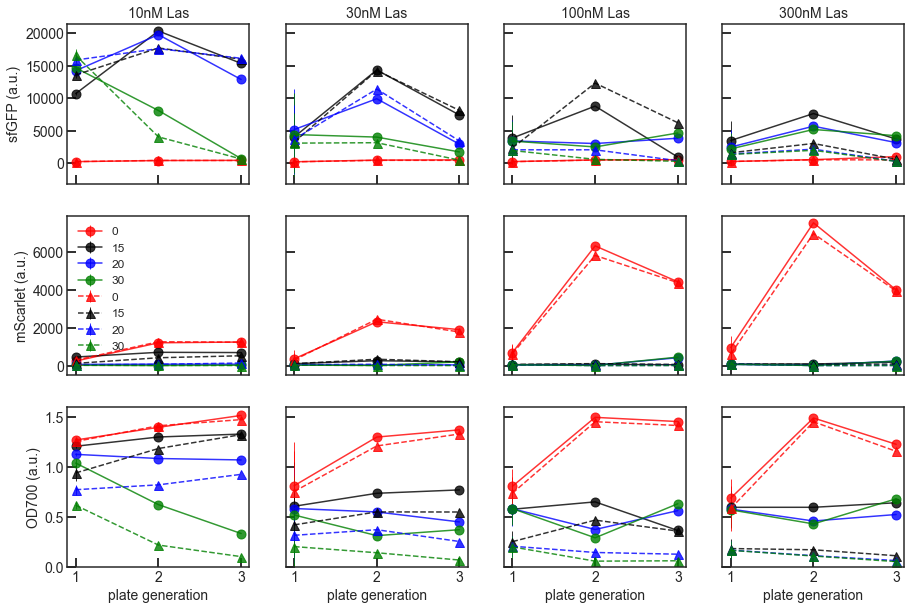

In [15]:
# plots for 2x differetiation (S7 and S9) set cole to 'carb' to get ampR/carb plot
# solid lines are 10uM IPTG, solid are 50uM IPTG
strain = 'split pir 2x bxb1'
iptgs = [10,50]
las_concs = df_OD700_avg.las.unique()
sal_concs = df_OD700_avg.sal.unique()
df_dict = {'GFP':df_GFP_avg,'RFP':df_RFP_avg,'OD700':df_OD700_avg}
fig, ax = plt.subplots(3,4,figsize=(15,10),sharex=True,sharey='row')
channels = ['GFP','RFP','OD700']
cole1='kan' # set to 'carb' to get ampR/carb plot
for i, las in enumerate(las_concs):
    ax[0,i].set_title(f'{int(1000*las)}nM Las',fontsize=14)
    ax[2,i].set_xlabel('plate generation',fontsize=14)
    for k, sal in enumerate(sal_concs):
        for j, channel in enumerate(channels):
            df = df_dict[channel]
            df_plot = df.loc[(df.strain==strain)&\
                             (df.las==las)&\
                             (df.sal==sal)&\
                             (df.iptg==10)&\
                             (df.cole1==cole1),:]
            ax[j,i].errorbar(df_plot['plate'].values,
                             df_plot['measurement'].values,
                             yerr=df_plot['std'].values,
                             linestyle='-',marker='o',color=sns.color_palette()[k],alpha=0.8,lw=1.5,
                            errorevery=5,elinewidth=1)
for i, las in enumerate(las_concs):
    ax[0,i].set_title(f'{int(1000*las)}nM Las',fontsize=14)
    ax[2,i].set_xlabel('plate generation',fontsize=14)
    for k, sal in enumerate(sal_concs):
        for j, channel in enumerate(channels):
            df = df_dict[channel]
            df_plot = df.loc[(df.strain==strain)&\
                             (df.las==las)&\
                             (df.sal==sal)&
                             (df.iptg==50)&\
                             (df.cole1==cole1)]
            ax[j,i].errorbar(df_plot['plate'].values,
                             df_plot['measurement'].values,
                             yerr=df_plot['std'].values,
                             linestyle='--',marker='^',color=sns.color_palette()[k],alpha=0.8,lw=1.5,
                            errorevery=5,elinewidth=1)
ax[2,0].set_ylim(0,1.6)
ax[0,0].set_ylabel('sfGFP (a.u.)',fontsize=14)
ax[1,0].set_ylabel('mScarlet (a.u.)',fontsize=14)
ax[2,0].set_ylabel('OD700 (a.u.)',fontsize=14)
ax[1,0].legend(['0','15','20','30','0','15','20','30'],fontsize=12,loc='best')
plt.savefig(f'./20211209_diff_inducer_grid_las_sal_grad_2xdiff_{cole1}.pdf')